In [34]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [35]:
def load_data():
    # Read data
    data_dir = Path("C:/ACTUAL_FOLDERS/Jupyter_Projects/Titanic_Competition/Titanic_Competition_Two/Titanic_Competition") # Replace with wherever you have your data, terrible path I know
    df_train = pd.read_csv(data_dir / "train.csv", index_col="PassengerId")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="PassengerId")

    # Preprocessing
    df_train = clean(df_train)
    df_train = impute(df_train)
    df_train = deal_with_cabin(df_train)

    # Binning & Encoding - Make into separate step if this gets any longer
    df_train['Fare'] = pd.qcut(df_train['Fare'], 12) # Binning Fare as looking at fare otherwise is very difficult to read
    df_train['Fare'] = LabelEncoder().fit_transform(df_train['Fare']) # Label encoding Fare
    df_train = pd.get_dummies(df_train, columns=['Sex', 'Embarked', 'Cabin_Letter'], drop_first = True)
    df_train['Age'] = pd.qcut(df_train['Age'], 10) # Binning Age as there exist distinct groupings
    df_train['Age'] = LabelEncoder().fit_transform(df_train['Age']) # Label encoding Age
    
    df_test = clean(df_test)
    df_test = impute(df_test)
    df_test = deal_with_cabin(df_test)
    
    # Binning & Encoding
    df_test['Fare'] = pd.qcut(df_test['Fare'], 12) # Binning Fare as looking at fare otherwise is very difficult to read
    df_test['Fare'] = LabelEncoder().fit_transform(df_test['Fare']) # Label encoding Fare
    df_test['Age'] = pd.qcut(df_test['Age'], 10) # Binning Age as there exist distinct groupings
    df_test['Age'] = LabelEncoder().fit_transform(df_test['Age']) # Label encoding Age
    df_test = pd.get_dummies(df_test, columns=['Sex', 'Embarked', 'Cabin_Letter'], drop_first = True)
    
    return df_train, df_test

In [36]:
data_dir = Path("C:/ACTUAL_FOLDERS/Jupyter_Projects/Titanic_Competition/Titanic_Competition_Two/Titanic_Competition")
df = pd.read_csv(data_dir / "train.csv", index_col="PassengerId")

df.select_dtypes(include=['object']) # 5 cat columns

# Take a look at the listed cat columns
cols = df.columns
df_num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(df_num_cols))
cat_cols
# Drop name, can't conceive of a way that's going to be relevant to survival

['Embarked', 'Sex', 'Name', 'Ticket', 'Cabin']

In [37]:
# Identify missing data
missing_data = df.isnull().sum()
# List columns with missing data & how many rows in each one is missing data
print(missing_data[missing_data > 0]) # Data missing from Age, Cabin, Embarked

# With well over half of Cabin missing & it being a categorical column with unique categories for every passenger, removing it is tempting.
# That said, could split Cabin entries up into letter & # to get location categories, which is undoubtedly very relevant.
# Further looking into this has revealed that the first Letter of cabin relates to a section of the ship.

# The missing Embarked values can be imputed with the mode, sometimes ticket number includes location but not for either missing values here

# Missing Age.. not sure. Mode again? It'll probably be related to other columns, look into that.

Age         177
Cabin       687
Embarked      2
dtype: int64


In [38]:
# Check for category typos
#df.Sex.unique() # No typos
#df.Embarked.unique() # No typos
#df.Ticket.unique() # Naturally, tickets are unique. From this we can see that many tickets aren't simply numbers however, but also include letters that sometimes relate to point of embarkation.

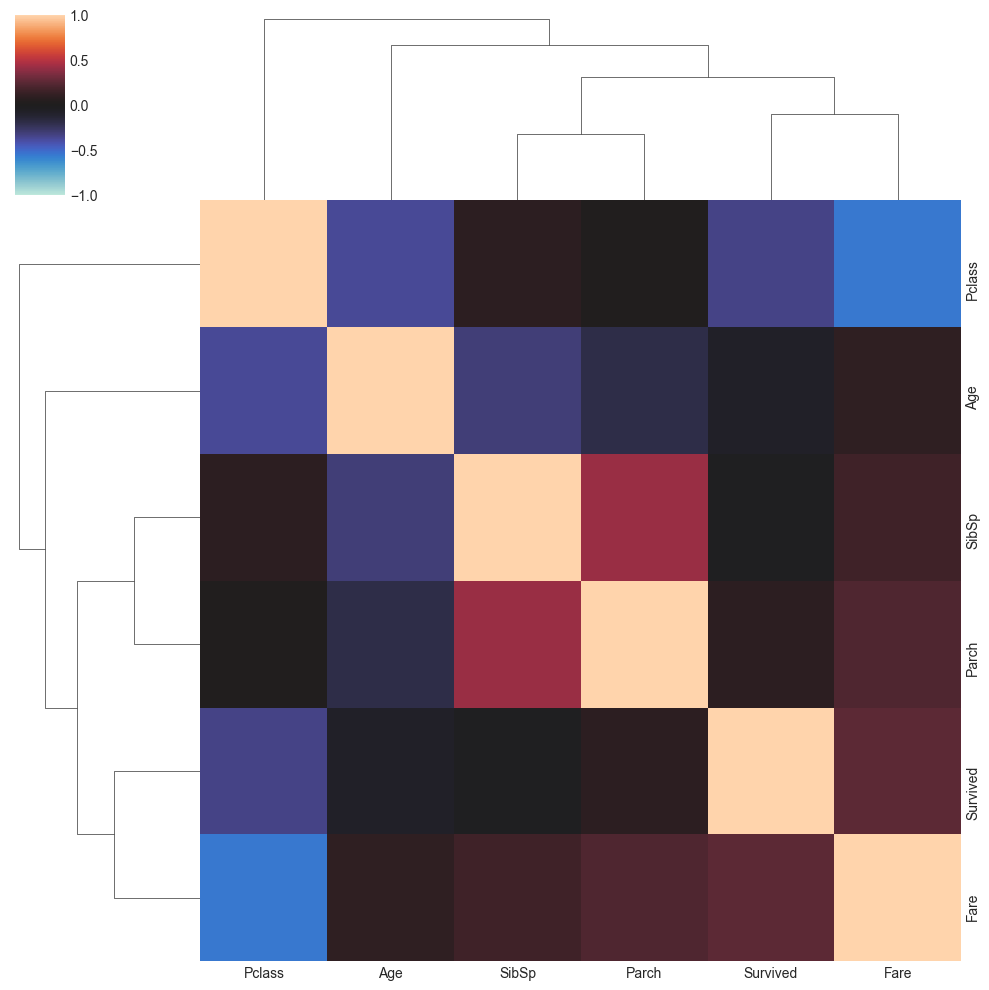

In [39]:
# Investigate correlation between numeric values
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df, annot=None)

# From this we can see that age most strongly interacts with class, suggesting that missing age values should be tied to class
# We can also see that Fare is related to Parch & SibSp

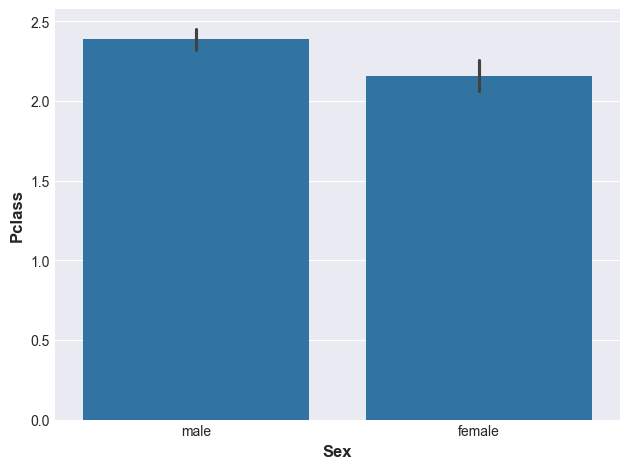

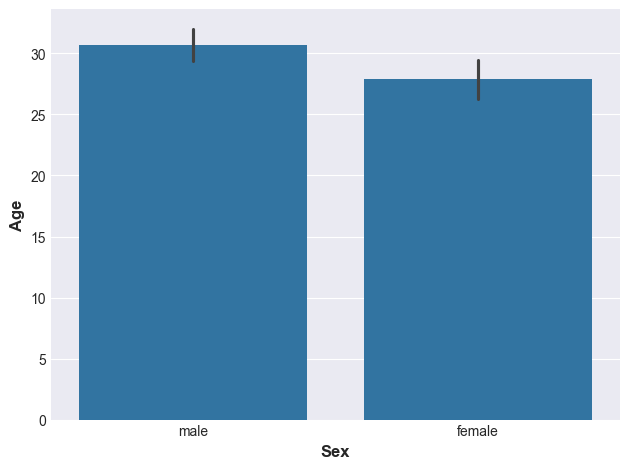

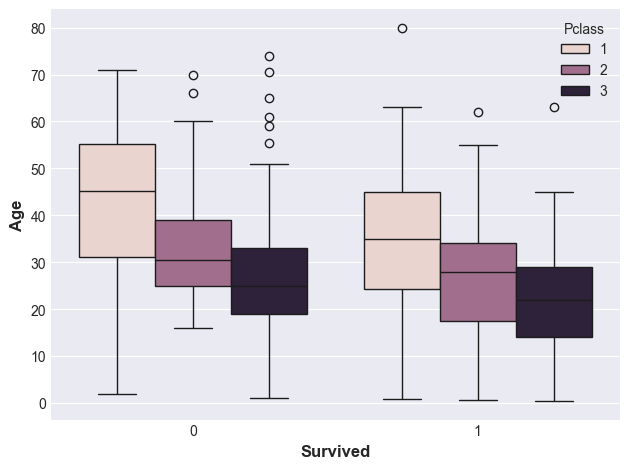

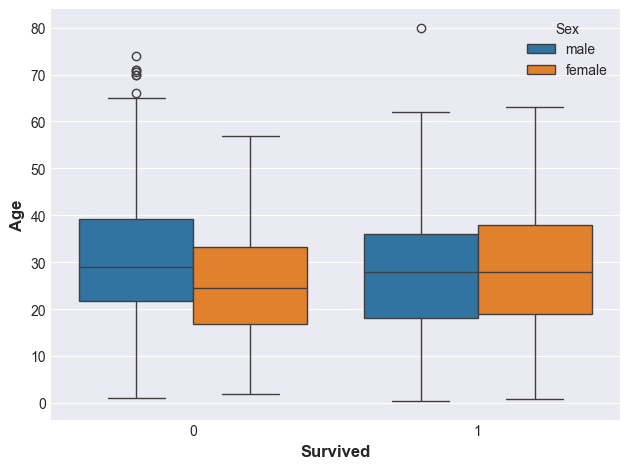

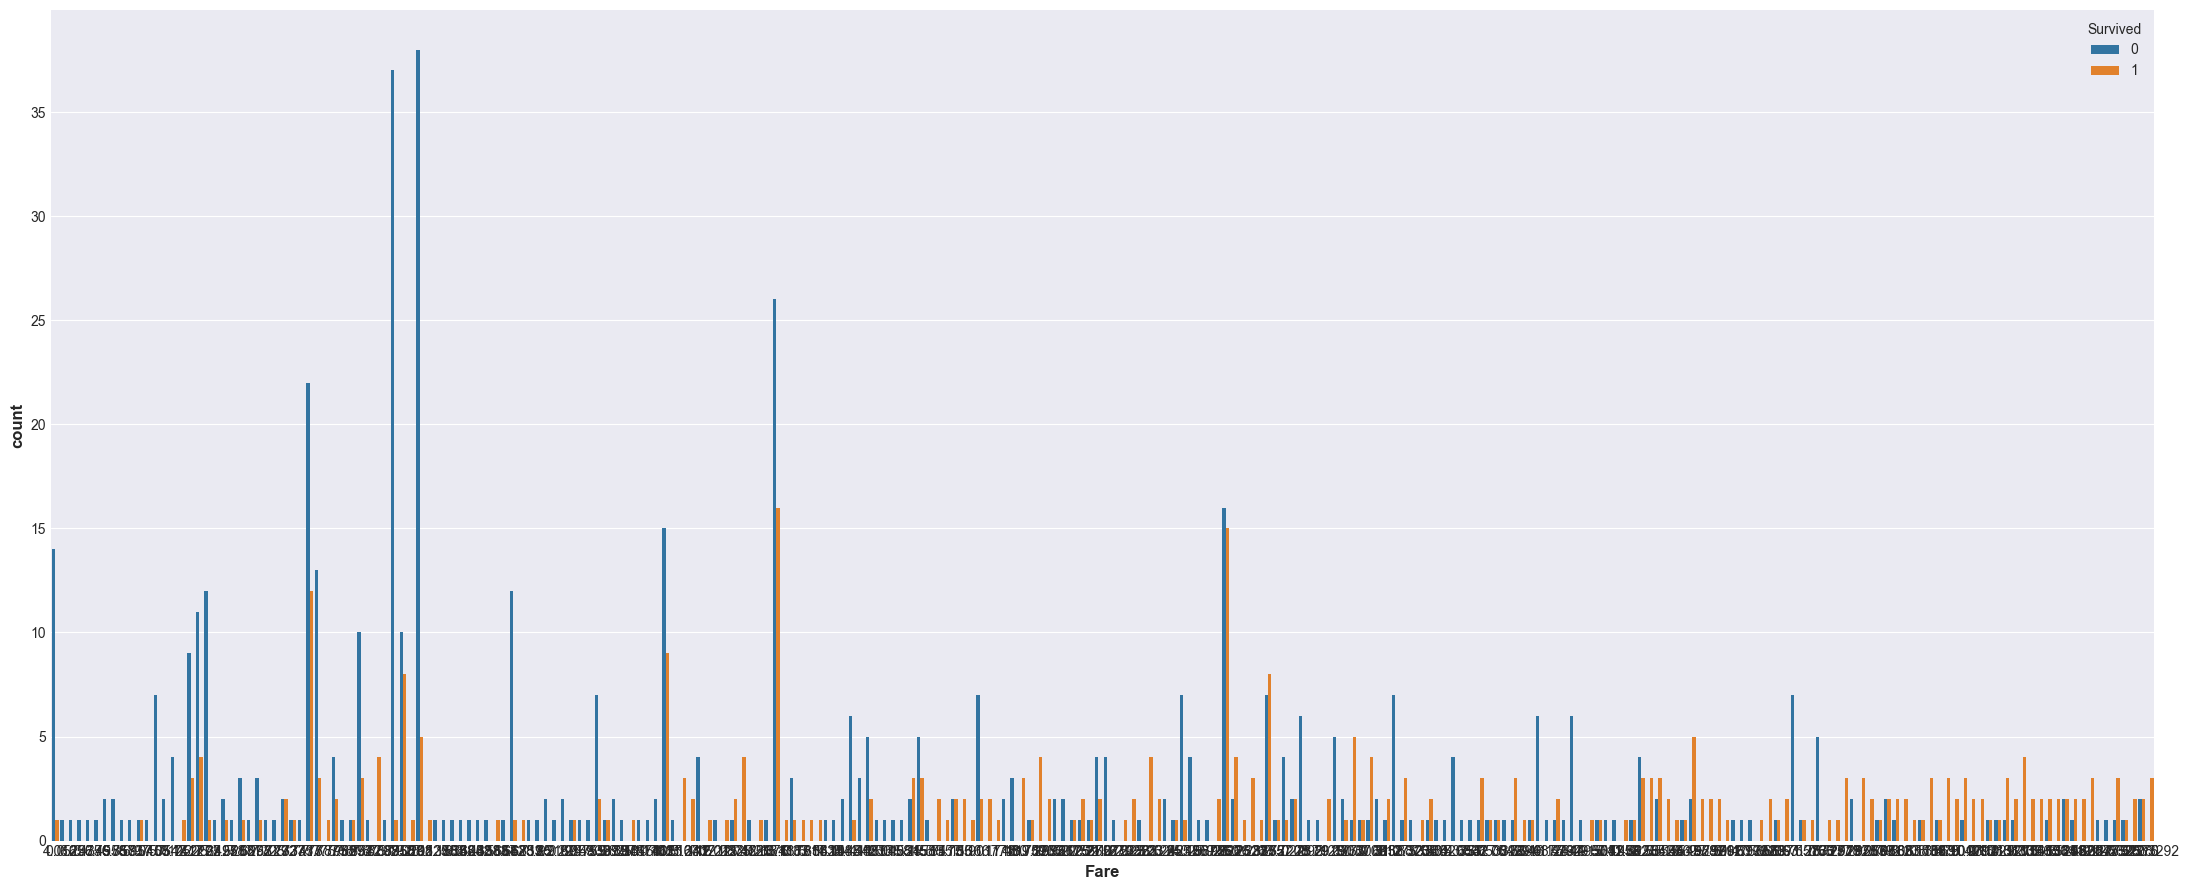

In [40]:
sns.barplot(data=df, x='Sex', y='Pclass') # A higher ratio of men with higher class tickets than women, though not by much
plt.show()

sns.barplot(data=df, x='Sex', y='Age') # A higher ratio of men are older
plt.show()

sns.boxplot(data=df, x='Survived', y= 'Age', hue='Pclass') # Older age is strongly correlated with higher class tickets, younger age is associated with survival
plt.show()

sns.boxplot(data=df, x='Survived', y= 'Age', hue='Sex') # Slightly more women than men survived. Surviving women were older than dead women. Surviving men were younger than dead men.
plt.show()

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(data=df, x='Fare', hue='Survived') # Unreadable.. bin in load_data
plt.show()

In [41]:
def clean(df):
        # Nothing Ⅰ'd consider cleaning as it stands
    return df

In [42]:
# Imputation strategies taken from here: https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410
def impute(df):
    df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median())) # group by class & sex as there is variation along both
    df['Embarked'] = df['Embarked'].fillna('S') # Googling the names of the people here lets us find out where they embarked from
    
    # Filling the missing value in Fare with the median Fare of 3rd class alone passenger (as that is the quality of this person who is missing a value for Fare)
    med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    df['Fare'] = df['Fare'].fillna(med_fare)

    # Dropping unuseful categories
    df = df.drop(['Name'], axis=1)
    df = df.drop(['Ticket'], axis=1) # This could hold information I'm not aware of, if ticket # related to location in the ship or to class

    # Anything remaining I either haven't looked at closely yet or is well-suited for a simple 0/"None" imputation
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

### Split the cabin up into cabin letters for locational data ###

In [43]:
def deal_with_cabin(df):
    df['Cabin_Letter'] = df['Cabin'].astype(str).str[0]
    df = df.drop(['Cabin'], axis=1)
    df['Cabin_Letter'] = df['Cabin_Letter'].replace(['A', 'B', 'C', 'T'], 'ABCT') # Based on analysis, 3 distinct groups. ABCT are 1st-class only
    df['Cabin_Letter'] = df['Cabin_Letter'].replace(['D', 'E'], 'DE') # Mixed classes, though leaning towards 1st
    df['Cabin_Letter'] = df['Cabin_Letter'].replace(['F', 'G'], 'FG') # G is entirely 3rd class, F is middling between 3rd & 2nd
    return df

## Load Data & Analyse ##

In [44]:
df_train, df_test = load_data()
X_train = df_train.copy()
X_test = df_test.copy()
y_train = X_train.pop("Survived")
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Cabin_Letter_DE,Cabin_Letter_FG,Cabin_Letter_n
PassengerId,,,,,,,,,,,
1,3,2,1,0,0,True,False,True,False,False,True
2,1,7,1,0,10,False,False,False,False,False,False
3,3,4,0,0,3,False,False,True,False,False,True
4,1,7,1,0,10,False,False,True,False,False,False
5,3,7,0,0,3,True,False,True,False,False,True


In [45]:
# These charts are currently broken as I have now encoded Cabin_Letter before getting here
#X_train['Cabin_Letter'].value_counts() # Only one person in cabin T
#sns.barplot(x=X_train['Cabin_Letter'], y=X_train['Pclass'], hue=y_train) # ABC & T contain ONLY 1st class passengers, and G only contains 3rd class passengers. 
#plt.show()                                                               # DE has a higher ratio of survival, FG & n have lower ratios of survival. ABCT is evenly split.


#fig, axs = plt.subplots(figsize=(22, 9))
#sns.countplot(x=X_train['Fare'], hue=y_train) # Much better, very clear correlation between fare & survivability
#plt.show()

In [46]:
from sklearn.linear_model import LogisticRegression # For binary classification

clf = LogisticRegression()
clf.fit(X_train, y_train.ravel())

print(clf.score(X_train, y_train))

0.8013468013468014


In [47]:
predictions = clf.predict(X_test)
submission = pd.DataFrame({'PassengerId' : X_test.index, 'Survived': predictions })
print(submission.head())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [48]:
filename= 'titanic predictions.csv'
submission.to_csv(filename, index=False)
print("Submission created!")

Submission created!
